In [1]:
import pandas as pd

df_ff_train = pd.read_csv("tep_faultfree_training.csv")
df_ff_test = pd.read_csv("tep_faultfree_testing.csv")
df_f_train = pd.read_csv("tep_faulty_training.csv")
df_f_test = pd.read_csv("tep_faulty_testing.csv")

df_ff_train["label"] = 0
df_f_train["label"] = 1
df_ff_test["label"] = 0
df_f_test["label"] = 1

df_train_combined = pd.concat(
    [df_ff_train, df_f_train],
    axis=0,          
    ignore_index=True
)

df_test_combined = pd.concat(
    [df_ff_test, df_f_test],
    axis=0,
    ignore_index=True
)

from sklearn.preprocessing import StandardScaler
import numpy as np

def scale_df(df, scaler):

    features_scaled = scaler.transform(df.iloc[:, :55])
    labels = df.iloc[:, 55:56].to_numpy().reshape(-1, 1)
    X_scaled = np.hstack([features_scaled, labels])
    df_scaled = pd.DataFrame(X_scaled, columns=df.columns, index=df.index)

    return df_scaled

scaler = StandardScaler()
scaler.fit(df_ff_train.iloc[:, :55])
df_ff_train = scale_df(df_ff_train, scaler)
df_test_combined = scale_df(df_test_combined, scaler)
df_train_combined = scale_df(df_train_combined, scaler)

print(df_ff_train.shape, df_test_combined.shape)
print(df_test_combined["label"].value_counts())

(25000, 56) (110400, 56)
label
1.0    62400
0.0    48000
Name: count, dtype: int64


## PCA setup - same as task 1

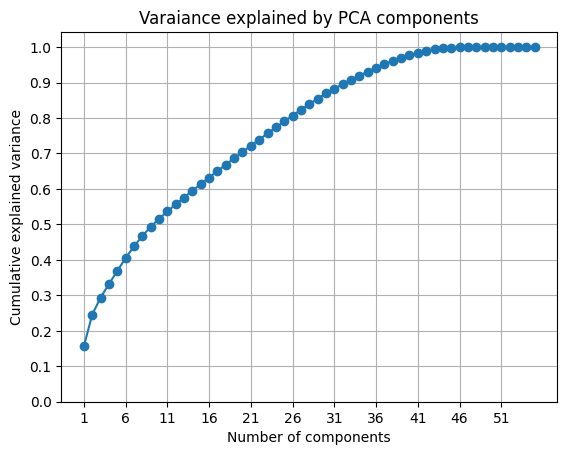

Explained variance by the first 10 components:
PC1: 15.59%
PC2: 8.92%
PC3: 4.83%
PC4: 3.79%
PC5: 3.73%
PC6: 3.63%
PC7: 3.29%
PC8: 2.93%
PC9: 2.59%
PC10: 2.23%


In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_train = df_ff_train.iloc[:, :55].values
y_train = df_ff_train["label"].values

X_test = df_test_combined.iloc[:, :55].values
y_test = df_test_combined["label"].values

pca3 = PCA(n_components=55)
pca3.fit(X_train)

x = np.arange(1, len(pca3.explained_variance_ratio_[0:-1]) + 2)

plt.plot(x,np.cumsum(pca3.explained_variance_ratio_),marker='o')
plt.title('Varaiance explained by PCA components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.xticks(range(1, 56, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.show()

print("Explained variance by the first 10 components:")
for i in range(10):
    print(f"PC{i+1}: {pca3.explained_variance_ratio_[i]*100:.2f}%")


pca3 = PCA(n_components=21)
pca3.fit(X_train)

X_test_pca = pca3.transform(X_test)
X_train_pca = pca3.transform(X_train)

## KMeans clustering

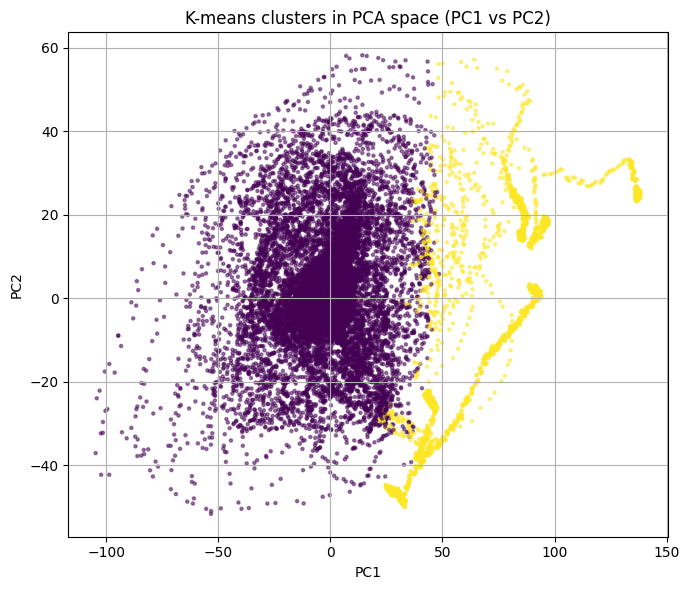

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k = 2
kmeans = KMeans(n_clusters=k, random_state=69, n_init='auto').fit(X_test_pca)
cluster_test = kmeans.predict(X_test_pca)

plt.figure(figsize=(7, 6))

plt.scatter(
    X_test_pca[:, 0],
    X_test_pca[:, 1],
    c=cluster_test,     
    cmap='viridis',
    s=5,
    alpha=0.5
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means clusters in PCA space (PC1 vs PC2)")
plt.grid(True)
plt.tight_layout()
plt.show()

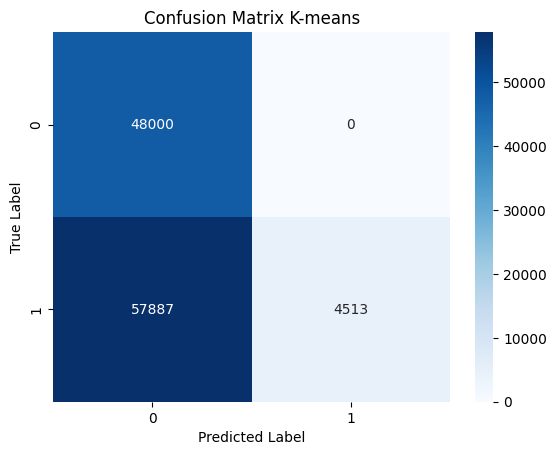

              precision    recall  f1-score   support

         0.0       0.45      1.00      0.62     48000
         1.0       1.00      0.07      0.13     62400

    accuracy                           0.48    110400
   macro avg       0.73      0.54      0.38    110400
weighted avg       0.76      0.48      0.35    110400



In [27]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

cf = confusion_matrix(y_test, cluster_test)
# Plot
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix K-means")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, cluster_test))

## DBSCAN

### KNN elbow

In [30]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=21)
neighbors_fit = neighbors.fit(X_test_pca)
distances, indices = neighbors_fit.kneighbors(X_test_pca)
distances = np.sort(distances[:, -1])

In [29]:
plt.figure(figsize=(7,5))
plt.plot(distances)
plt.title("k-distance graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("20th nearest neighbor distance")
# plt.xlim(80000, 115000)
plt.ylim(0, 20)
plt.grid(True)
plt.show()

NameError: name 'distances' is not defined

<Figure size 700x500 with 0 Axes>

## DBSCAN

### note
when running eps values too high, we oobviously include more noise into clusters 

In [ ]:
from sklearn.cluster import DBSCAN
import json
from sklearn.metrics import confusion_matrix, accuracy_score

eps_values = np.arange(4.8 ,5.2, 0.1)

min_samples_list = []
loop_counter=0
total_loops = len(eps_values) * len(min_samples_list)

for eps in eps_values:
        
    for min_samples in min_samples_list:
        loop_counter += 1
        print(f"[{loop_counter}/{total_loops}] Running DBSCAN with eps={eps}, min_samples={min_samples}")
        db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=1).fit(X_test_pca)
        db_labels = db.labels_

        y_pred = np.where(db_labels == -1, 1, 0)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)
        fnr = fn / (fn + tp)
        fpr = fp / (fp + tn)

        outliers = np.sum(db_labels == -1)
        ratio_outliers = outliers / (np.sum(y_test == 1))

        accuracy = accuracy_score(y_test, y_pred)

        entry = {
            "eps": float(eps),
            "min_samples": int(min_samples),
            "precision": float(precision),
            "recall": float(recall),
            "f1": float(f1),
            "fnr": float(fnr),
            "fpr": float(fpr),
            "accuracy": float(accuracy),
            "outliers": int(outliers),
            "outlier_ratio": float(ratio_outliers),
            "y_pred": y_pred.tolist(),
            "db_labels": db_labels.tolist()
            }
        
        with open("DBscan_results.jsonl", "a") as f:
                f.write(json.dumps(entry) + "\n")


[1/25] Running DBSCAN with eps=4.8, min_samples=10
[2/25] Running DBSCAN with eps=4.8, min_samples=15
[3/25] Running DBSCAN with eps=4.8, min_samples=25
[4/25] Running DBSCAN with eps=4.8, min_samples=30
[5/25] Running DBSCAN with eps=4.8, min_samples=35
[6/25] Running DBSCAN with eps=4.8999999999999995, min_samples=10
[7/25] Running DBSCAN with eps=4.8999999999999995, min_samples=15
[8/25] Running DBSCAN with eps=4.8999999999999995, min_samples=25
[9/25] Running DBSCAN with eps=4.8999999999999995, min_samples=30
[10/25] Running DBSCAN with eps=4.8999999999999995, min_samples=35
[11/25] Running DBSCAN with eps=4.999999999999999, min_samples=10
[12/25] Running DBSCAN with eps=4.999999999999999, min_samples=15
[13/25] Running DBSCAN with eps=4.999999999999999, min_samples=25
[14/25] Running DBSCAN with eps=4.999999999999999, min_samples=30
[15/25] Running DBSCAN with eps=4.999999999999999, min_samples=35
[16/25] Running DBSCAN with eps=5.099999999999999, min_samples=10
[17/25] Running DB

In [32]:
results_df = pd.read_json('DBscan_results.jsonl',lines=True)
pd.set_option('display.max_rows', None)
results_df.iloc[:,:10].sort_values(by=["f1"], ascending=False)

,eps,min_samples,precision,recall,f1,fnr,fpr,accuracy,outliers,outlier_ratio
28,2.5,50,0.562743,0.989391,0.717429,0.010609,0.999396,0.559484,109709,1.758157
45,2.6,45,0.562139,0.986843,0.716268,0.013157,0.999271,0.558098,109544,1.755513
27,2.5,40,0.561822,0.985529,0.715664,0.014471,0.999229,0.557373,109460,1.754167
50,2.7,45,0.561568,0.984391,0.715158,0.015609,0.999104,0.556784,109383,1.752933
2,2.5,30,0.561523,0.984295,0.715097,0.015705,0.999188,0.556694,109381,1.752901
26,2.5,30,0.561523,0.984295,0.715097,0.015705,0.999188,0.556694,109381,1.752901
1,2.5,25,0.561247,0.983045,0.714542,0.016955,0.999042,0.556051,109296,1.751538
44,2.6,40,0.561225,0.982981,0.714508,0.017019,0.999062,0.556005,109293,1.751490
43,2.6,35,0.561093,0.982372,0.714240,0.017628,0.998979,0.555697,109251,1.750817
55,2.8,45,0.561132,0.982115,0.714203,0.017885,0.998562,0.555734,109215,1.750240


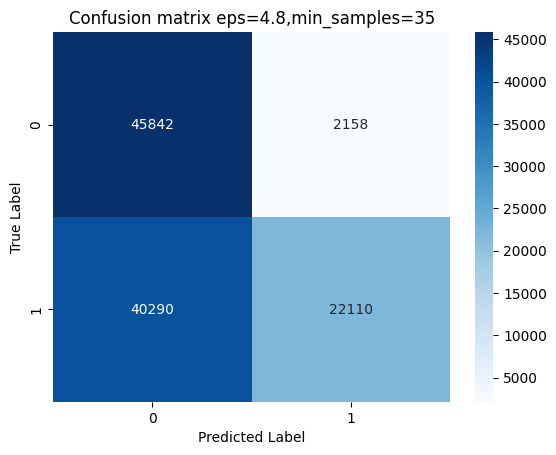

              precision    recall  f1-score   support

         0.0       0.53      0.96      0.68     48000
         1.0       0.91      0.35      0.51     62400

    accuracy                           0.62    110400
   macro avg       0.72      0.65      0.60    110400
weighted avg       0.75      0.62      0.59    110400



In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

row = 95
y_pred = results_df.loc[row, "y_pred"]
cm2 = confusion_matrix(y_test, y_pred)
labels = results_df.loc[row,"db_labels"]
eps = results_df.loc[row,"eps"]
min_samples = results_df.loc[row,"min_samples"]

sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion matrix eps={eps},min_samples={min_samples}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, y_pred))


I think that this should be the most balanced results, although we can aim for a high recall

## HDBSCAN

In [12]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import json
from hdbscan import approximate_predict, HDBSCAN


min_cluster_size_list = [20,30,40]
min_samples_list = [1,2,3,4]

results = [] 
y_pred_list = []

total_loops = len(min_cluster_size_list) * len(min_samples_list)
loop_counter = 0

for min_cluster_size in min_cluster_size_list:
    for min_samples in min_samples_list:

        loop_counter += 1
        print(f"[{loop_counter}/{total_loops}] Running HDBSCAN with min_cluster_size={min_cluster_size}, min_samples={min_samples}")

        hdb = HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            prediction_data=True,
        )
        hdb.fit(X_train_pca)
        hdb_labels, strengths = approximate_predict(hdb, X_test_pca)
        y_pred = np.where(hdb_labels == -1, 1, 0)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)
        fnr = fn / (fn + tp)
        fpr = fp / (fp + tn)

        outliers = np.sum(hdb_labels == -1)
        ratio_outliers = outliers / np.sum(y_test == 1)
        accuracy = accuracy_score(y_test, y_pred)

        entry = {
            "min_cluster_size": int(min_cluster_size),
            "min_samples": int(min_samples),
            "precision": float(precision),
            "recall": float(recall),
            "f1": float(f1),
            "fnr": float(fnr),
            "fpr": float(fpr),
            "accuracy": float(accuracy),
            "outliers": int(outliers),
            "outlier_ratio": float(ratio_outliers),
            "y_pred": y_pred.tolist(),
            "hdb_labels": hdb_labels.tolist()
        }
        results.append(entry)

        with open("HDBscan_results3.jsonl", "a") as f:
            f.write(json.dumps(entry) + "\n")


[1/12] Running HDBSCAN with min_cluster_size=20, min_samples=1


/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[2/12] Running HDBSCAN with min_cluster_size=20, min_samples=2


/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/hdbscan/prediction.py:391: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:

[3/12] Running HDBSCAN with min_cluster_size=20, min_samples=3


/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/hdbscan/prediction.py:391: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[4/12] Running HDBSCAN with min_cluster_size=20, min_samples=4


/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/hdbscan/prediction.py:391: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[5/12] Running HDBSCAN with min_cluster_size=30, min_samples=1
[6/12] Running HDBSCAN with min_cluster_size=30, min_samples=2


/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/hdbscan/prediction.py:391: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:

[7/12] Running HDBSCAN with min_cluster_size=30, min_samples=3


/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/hdbscan/prediction.py:391: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[8/12] Running HDBSCAN with min_cluster_size=30, min_samples=4


/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/hdbscan/prediction.py:391: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[9/12] Running HDBSCAN with min_cluster_size=40, min_samples=1


/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/hdbscan/prediction.py:391: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[10/12] Running HDBSCAN with min_cluster_size=40, min_samples=2


/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/hdbscan/prediction.py:391: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[11/12] Running HDBSCAN with min_cluster_size=40, min_samples=3


/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/hdbscan/prediction.py:391: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[12/12] Running HDBSCAN with min_cluster_size=40, min_samples=4


/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/hdbscan/prediction.py:391: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'


In [13]:
hdb3_df = pd.read_json('HDBscan_results3.jsonl',lines=True)
# top10 = hdb3_df.sort_values(
#     by=["f1"],
#     ascending=False
# ).head(10)

hdb3_df.iloc[:,:10]

,min_cluster_size,min_samples,precision,recall,f1,fnr,fpr,accuracy,outliers,outlier_ratio
0,1000,30,0.565217,1.000000,0.722222,0.000000,1.000000,0.565217,110400,1.769231
1,50,10,0.565217,1.000000,0.722222,0.000000,1.000000,0.565217,110400,1.769231
2,50,30,0.565217,1.000000,0.722222,0.000000,1.000000,0.565217,110400,1.769231
3,50,50,0.565217,1.000000,0.722222,0.000000,1.000000,0.565217,110400,1.769231
4,100,10,0.565217,1.000000,0.722222,0.000000,1.000000,0.565217,110400,1.769231
5,100,30,0.565217,1.000000,0.722222,0.000000,1.000000,0.565217,110400,1.769231
6,100,50,0.565217,1.000000,0.722222,0.000000,1.000000,0.565217,110400,1.769231
7,150,10,0.565217,1.000000,0.722222,0.000000,1.000000,0.565217,110400,1.769231
8,150,30,0.565217,1.000000,0.722222,0.000000,1.000000,0.565217,110400,1.769231
9,150,50,0.565217,1.000000,0.722222,0.000000,1.000000,0.565217,110400,1.769231


#### Higher values

In [24]:
hdb2_df = pd.read_json('HDBscan_results2.jsonl',lines=True)
top10 = hdb2_df.sort_values(
    by=["f1"],
    ascending=False
).head(10)

top10.iloc[:,:10]

,min_cluster_size,min_samples,precision,recall,f1,fnr,fpr,accuracy,outliers,outlier_ratio
3,200,40,0.958450,0.252115,0.399218,0.747885,0.014208,0.571105,16414,0.263045
5,300,40,0.958450,0.252115,0.399218,0.747885,0.014208,0.571105,16414,0.263045
7,400,40,0.958432,0.252003,0.399076,0.747997,0.014208,0.571042,16407,0.262933
1,100,40,0.958064,0.249696,0.396146,0.750304,0.014208,0.569737,16263,0.260625
0,100,20,0.980323,0.226747,0.368305,0.773253,0.005917,0.560371,14433,0.231298
2,200,20,0.980030,0.223349,0.363791,0.776651,0.005917,0.558451,14221,0.227901
4,300,20,0.980030,0.223349,0.363791,0.776651,0.005917,0.558451,14221,0.227901
6,400,20,0.980015,0.223189,0.363577,0.776811,0.005917,0.558361,14211,0.227740


#### Lower values

In [21]:
hdb_df = pd.read_json('HDBscan_results.json')
top10 = hdb_df.sort_values(
    by=["outlier_ratio"],
    ascending=False
).head(10)

print(top10.iloc[:,:10])

    min_cluster_size  min_samples  precision    recall        f1       fnr  \
20                 9           20   0.469759  0.670641  0.552507  0.329359   
50                15           20   0.469358  0.669647  0.551893  0.330353   
10                 7           20   0.469468  0.669744  0.552001  0.330256   
40                13           20   0.468992  0.668622  0.551291  0.331378   
80                21           20   0.468878  0.668429  0.551147  0.331571   
70                19           20   0.468813  0.668253  0.551042  0.331747   
60                17           20   0.468728  0.667997  0.550896  0.332003   
30                11           20   0.468789  0.668077  0.550966  0.331923   
0                  5           20   0.468933  0.668109  0.551076  0.331891   
4                  5           28   0.707576  0.371058  0.486822  0.628942   

         fpr  accuracy  outliers  outlier_ratio  
20  0.984083  0.385978     89084       1.427628  
50  0.984208  0.385362     89028       1.

### Results

After running the HBDSCAN for way too long

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_pred = hdb2_df.loc[3, "y_pred"]
cm3 = confusion_matrix(y_test, y_pred)
labels = hdb2_df.loc[3 ,"hdb_labels"]

outliers = labels == -1
normal = labels != -1

sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues')
plt.title("Confution matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, y_pred))